This notebook provides an introduction to the basic concepts of machine learning.

Let's start by generating some data to work with.  Let's say that we have a dataset that has tested people on two continuous measures (processing speed and age) and one discrete measure (diagnosis with any psychiatric disorder).  First let's create the continuous data assuming that there is a relationship between these two variables.  We will make a function to generate a new dataset, since we will need to do this multiple times.

In [185]:
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import PolynomialFeatures,scale

recreate=True
if recreate:
    seed=20698
else:
    seed=numpy.ceil(numpy.random.rand()*100000).astype('int')
    print(seed)

numpy.random.seed(seed)

def make_continuous_data(mean=[45,100],var=[10,10],cor=-0.6,N=100):
    """
    generate a synthetic data set with two variables
    """
    cor=numpy.array([[1.,cor],[cor,1.]])
    var=numpy.array([[var[0],0],[0,var[1]]])
    cov=var.dot(cor).dot(var)
    return numpy.random.multivariate_normal(mean,cov,N)

data R-squared: 0.425284


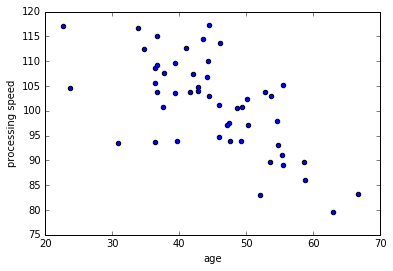

In [124]:
n=50
d=make_continuous_data(N=n)
plt.scatter(d[:,0],d[:,1])
plt.xlabel('age')
plt.ylabel('processing speed')

print('data R-squared: %f'%numpy.corrcoef(d.T)[0,1]**2)

What is the simplest story that we could tell about these data

In [125]:
mean=numpy.mean(d,0)
print(mean)

[  45.04570308  101.34298334]


Is there a relation between processing speed and age? Compute the linear regression equation to find out. 

In [126]:
slope,intercept,r,p,se=scipy.stats.linregress(d[:,0],d[:,1])

processing speed = 131.370054 + -0.666591*age
p =0.000000
rsquared=0.425284


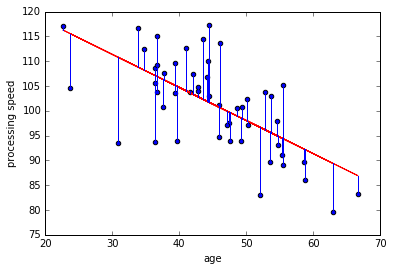

In [127]:
print('processing speed = %f + %f*age'%(intercept,slope))
print('p =%f'%p)

def get_RMSE(y,pred):
    return numpy.sqrt(numpy.mean((y - pred)**2))

def get_R2(y,pred):
    """ compute r-squared"""
    return numpy.corrcoef(y,pred)[0,1]**2

ax=plt.scatter(d[:,0],d[:,1])
plt.xlabel('age')
plt.ylabel('processing speed')
plt.plot(d[:,0], slope * d[:,0] + intercept, color='red')
# plot residual lines
d_predicted=slope*d[:,0] + intercept
for i in range(d.shape[0]):
    x=d[i,0]
    y=d[i,1]
    plt.plot([x,x],[d_predicted[i],y],color='blue')

RMSE=get_RMSE(d[:,1],d_predicted)
rsq=get_R2(d[:,1],d_predicted)
print('rsquared=%f'%rsq)

This shows us that linear regression can provide a simple description of a complex dataset - we can describe the entire dataset in 2 numbers. Now let's ask how good this description is for a new dataset generated by the same process:


R2 for new data: 0.376184


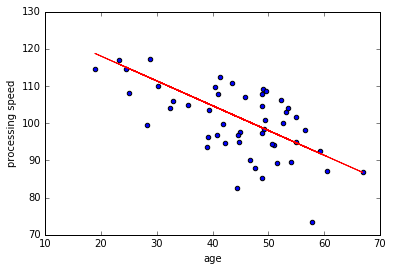

In [128]:
d_new=make_continuous_data(N=n)
d_new_predicted=intercept + slope*d_new[:,0]
RMSE_new=get_RMSE(d_new[:,1],d_new_predicted)
rsq_new=get_R2(d_new[:,1],d_new_predicted)
print('R2 for new data: %f'%rsq_new)

ax=plt.scatter(d_new[:,0],d_new[:,1])
plt.xlabel('age')
plt.ylabel('processing speed')
plt.plot(d_new[:,0], slope * d_new[:,0] + intercept, color='red')


Now let's do this 100 times and look at how variable the fits are.  

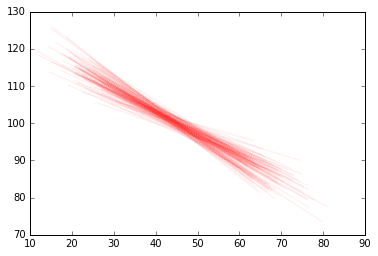

In [129]:
nruns=100
slopes=numpy.zeros(nruns)
intercepts=numpy.zeros(nruns)
rsquared=numpy.zeros(nruns)

fig = plt.figure()
ax = fig.gca()

for i in range(nruns):
    data=make_continuous_data(N=n)
    slopes[i],intercepts[i],_,_,_=scipy.stats.linregress(data[:,0],data[:,1])
    ax.plot(data[:,0], slopes[i] * data[:,0] + intercepts[i], color='red', alpha=0.05)
    pred_orig=intercept + slope*data[:,0]
    rsquared[i]=get_R2(data[:,1],pred_orig)


In [130]:
print('Original R2: %f'%rsq)
print('Mean R2 for new datasets on original model: %f'%numpy.mean(rsquared))


Original R2: 0.425284
Mean R2 for new datasets on original model: 0.373708


Now let's perform leave-one-out cross-validation on the original dataset, so that we can compare it to the performance on new datasets.  We expect that average LOO performance should be very similar to the Mean R2 for new datasets.

R2 for leave-one-out prediction: 0.372860


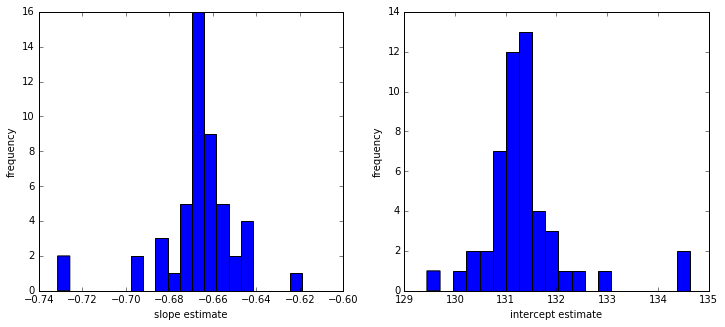

In [133]:
loo=LeaveOneOut()

slopes_loo=numpy.zeros(n)
intercepts_loo=numpy.zeros(n)
pred=numpy.zeros(n)

ctr=0
for train,test in loo.split(range(n)):
    slopes_loo[ctr],intercepts_loo[ctr],_,_,_=scipy.stats.linregress(d[train,0],d[train,1])
    pred[ctr]=intercepts_loo[ctr] + slopes_loo[ctr]*data[test,0]
    ctr+=1

print('R2 for leave-one-out prediction: %f'%get_R2(pred,data[:,1]))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
_=plt.hist(slopes_loo,20)
plt.xlabel('slope estimate')
plt.ylabel('frequency')
plt.subplot(1,2,2)
_=plt.hist(intercepts_loo,20)
plt.xlabel('intercept estimate')
plt.ylabel('frequency')


Now let's look at the effect of outliers on correlation and prediction.


R2 for regression with outlier: 0.607323


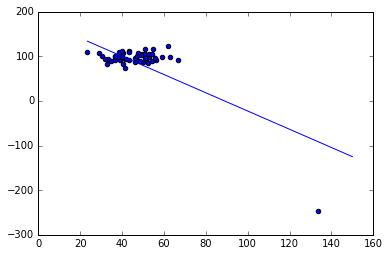

In [134]:
# add an outlier
data_null=make_continuous_data(N=n,cor=0.0)
outlier_multiplier=2.0

data=numpy.vstack((data_null,[numpy.max(data_null[:,0])*outlier_multiplier,
                         numpy.max(data_null[:,1])*outlier_multiplier*-1]))
plt.scatter(data[:,0],data[:,1])
slope,intercept,r,p,se=scipy.stats.linregress(data[:,0],data[:,1])
plt.plot([numpy.min(data[:,0]),intercept + slope*numpy.min(data[:,0])],
         [numpy.max(data[:,0]),intercept + slope*numpy.max(data[:,0])])
rsq_outlier=r**2
print('R2 for regression with outlier: %f'%rsq_outlier)

In [137]:
loo=LeaveOneOut()

pred_outlier=numpy.zeros(data.shape[0])

ctr=0
for train,test in loo.split(range(data.shape[0])):
    s,i,_,_,_=scipy.stats.linregress(data[train,0],data[train,1])
    pred_outlier[ctr]=i + s*data[test,0]
    ctr+=1

print('R2 for leave-one-out prediction: %f'%get_R2(pred_outlier,data[:,1]))

R2 for leave-one-out prediction: 0.004880


Now let's look at model complexity.  We will generate some data with a certain polynomial order, and see whether crossvalidation can find the right model order.  

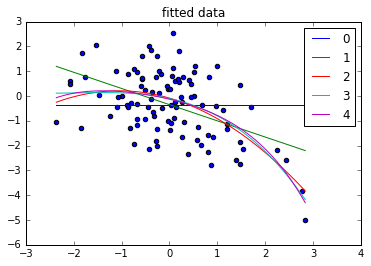

In [279]:
# from https://gist.github.com/iizukak/1287876
def gram_schmidt_columns(X):
    Q, R = numpy.linalg.qr(X)
    return Q

def make_continuous_data_poly(mean=0,var=1,betaval=5,order=1,N=100):
    """
    generate a synthetic data set with two variables
    allowing polynomial functions up to 5-th order
    """
    x=numpy.random.randn(N)
    x=x-numpy.mean(x)
    pf=PolynomialFeatures(5,include_bias=False)

    x_poly=gram_schmidt_columns(pf.fit_transform(x[:,numpy.newaxis]))

    betas=numpy.zeros(5)
    betas[0]=mean
    for i in range(order):
        betas[i]=betaval
    func=x_poly.dot(betas)+numpy.random.randn(N)*var
    d=numpy.vstack((x,func)).T
    return d,x_poly

n=100
trueorder=2
data,x_poly=make_continuous_data_poly(N=n,order=trueorder)

# fit models of increasing complexity
npolyorders=5

plt.figure()
plt.scatter(data[:,0],data[:,1])
plt.title('fitted data')

xp=numpy.linspace(numpy.min(data[:,0]),numpy.max(data[:,0]),100)

for i in range(npolyorders):
    f = numpy.polyfit(data[:,0], data[:,1], i)
    p=numpy.poly1d(f)
    plt.plot(xp,p(xp))
plt.legend(['%d'%i for i in range(npolyorders)])

# compute in-sample and out-of-sample error using LOO
loo=LeaveOneOut()
pred=numpy.zeros((n,npolyorders))
mean_trainerr=numpy.zeros(npolyorders)
prederr=numpy.zeros(npolyorders)

for i in range(npolyorders):
    ctr=0
    trainerr=numpy.zeros(n)
    for train,test in loo.split(range(data.shape[0])):
        f = numpy.polyfit(data[train,0], data[train,1], i)
        p=numpy.poly1d(f)
        trainerr[ctr]=numpy.sqrt(numpy.mean((data[train,1]-p(data[train,0]))**2))
        pred[test,i]=p(data[test,0])
        ctr+=1
    mean_trainerr[i]=numpy.mean(trainerr)
    prederr[i]=numpy.sqrt(numpy.mean((data[:,1]-pred[:,i])**2))
    

True order: 2
Order estimated by cross validation: 2


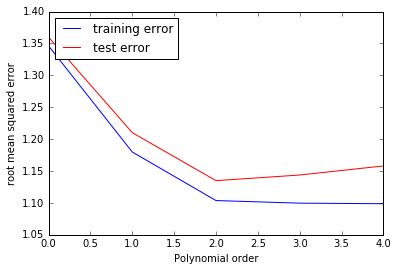

In [280]:
plt.plot(range(npolyorders),mean_trainerr)
plt.plot(range(npolyorders),prederr,color='red')
plt.xlabel('Polynomial order')
plt.ylabel('root mean squared error')
plt.legend(['training error','test error'],loc=2)

print('True order:',trueorder)
print('Order estimated by cross validation:',numpy.argmin(prederr))